In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from decimal import Decimal
from datetime import datetime
import re

%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import  isnan, when, count, col,isnull

%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [5]:
sns.set_context('talk')
%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('notebook')

In [9]:
data_folder = './data/'

In [ ]:
data = spark.read.csv(data_folder+'en.openfoodfacts.org.products.csv',header = True, sep="\t")

In [ ]:
data.columns

In [ ]:
selected = data.select(['code','countries','categories','origins','nutrition-score-fr_100g','packaging','-palmitic-acid_100g'])

In [ ]:
selected.count()

In [ ]:
ciao = data.select([(count(when(isnull(c), c))).alias(c) for c in data.columns])
ciaone = ciao.toPandas()

In [ ]:
pd.options.display.max_columns = 100000000
ciaone[ciaone<300000].dropna(axis=1)

In [10]:
data = spark.read.csv(data_folder+'en.openfoodfacts.org.products.csv',header = True, sep="\t")

N_subset = 0

if N_subset>0:
    rdd = spark.sparkContext.parallelize(data.take(N_subset))
    data = spark.createDataFrame(rdd, data.schema)

In [ ]:
data.select([count(when(isnan(c), c)).alias(c) for c in ['countries', 'countries_tags', 'countries_en']]).show()

In [7]:
none_ = data.rdd.filter(lambda r: r['countries_en'] == None)
print(none_.count())

599


In [16]:
data = data.na.drop(subset=['countries_en'])

In [ ]:
none_ = data.rdd.filter(lambda r: r['countries_en'] == None)
print(none_.count())

In [9]:
country_frequency = data.rdd.flatMap(lambda r: [(country, 1) for country in filter(None, r['countries_en'].split(','))]).reduceByKey(lambda a,b: a+b)

In [10]:
country_top10 = country_frequency.sortBy(lambda r: r[1], ascending = False).take(10)

In [11]:
country_top10_df = pd.DataFrame(country_top10, columns=['country', 'count']).set_index('country')

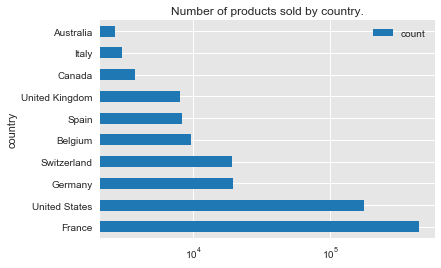

In [12]:
country_top10_df.plot(kind='barh', logx=True)
plt.title("Number of products sold by country.")
plt.show()

In [45]:
N_fr = country_top10_df.iloc[0]
N_us = country_top10_df.iloc[1]
N_all = sum([c[1] for c in country_frequency.countByValue().keys()])

In [59]:
(N_fr + N_us) / N_all

count    0.857237
dtype: float64

In [18]:
data_fr_us = data.rdd.filter(lambda r: re.match(r'United State|France', r['countries_en']))

In [21]:
data_fr_us_DF = data_fr_us.toDF(schema=data.schema)

In [24]:
data_fr_us_DF.count()

613398

In [22]:
data_fr_us_df = data_fr_us_DF.toPandas() 

Py4JJavaError: An error occurred while calling o283.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 5.0 failed 1 times, most recent failure: Lost task 4.0 in stage 5.0 (TID 26, localhost, executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:148)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:76)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:117)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:86)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:142)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3200)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3197)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3197)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:148)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:76)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:117)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:86)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:142)
	... 27 more


In [ ]:
palm_oil = data.select(['countries','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n'])

In [ ]:
palm_oil.count()

In [ ]:
palm_oil_noNAN = palm_oil.dropna()

In [ ]:
palm_oil_noNAN.count()

In [ ]:
palm_oil_noNAN.filter('ingredients_from_palm_oil_n != 0 ').count()

In [ ]:
palm_oil_flat = palm_oil.rdd.flatMap(lambda r: [(x, r['ingredients_from_palm_oil_n'], r['ingredients_that_may_be_from_palm_oil_n']) 
                                                for x in r['countries'].split()])

In [ ]:
palm_oil_flat.take(50)